In [1]:
!pip install tqdm fbprophet

In [2]:

COMPANY="AMZN"
TRAIN = 0.8
VALID='1w'
path = f'data/{COMPANY}.csv'

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm, chi2_contingency, normaltest, f_oneway, boxcox
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns
# check prophet version
import fbprophet
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import datetime
from matplotlib import pyplot

Importing plotly failed. Interactive plots will not work.


In [5]:
#### Utility functions




def rmse_calc(y_true,yhat):
    return math.sqrt(mean_squared_error(y_true, yhat))


def persistance_measure(percent=VALID,df=None):
    
    train, valid = split_by_date(df)

    history=[x for x in train]
    predictions = list()
    for i in range(len(valid)):
        yhat=history[-1]
        
        predictions.append(yhat)
        obs=valid[i]
      
        history.append(obs)
    
    return rmse_calc(valid,predictions)

    
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)
    
def box_cox_trans(data, lmbda=None):
    """
    | Function that transformes a given data with the Box Cox.
    :param data: a numpy array or list that is transformed
    :param lmbda: an optional parameter; None means calculating the
    new lambda otherwise using the argument lmbda
    :return: either the transformed data with the new lambda,
    or just transformed data
    """
    delta = abs(data.min()) + 1
    upper = delta + data
    if lmbda is None:
        xt, lam = boxcox(upper)
    else:
        xt = boxcox(upper, lmbda)
    to_down = xt - delta

    if lmbda is None:
        return to_down, lam
    return to_down

def histogram(series=None):

    plt.figure(1,figsize=(12,8))
    ax1=plt.subplot(211)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    # Only show ticks on the left and bottom spines

    series.hist()
    
    ax2 = plt.subplot(212)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    series.plot(kind='kde')
    plt.savefig(f'plots/{COMPANY}_hist_kde.png', dpi=300, bbox_inches='tight')
    plt.show()
    
def line(series=None):
    ax = plt.subplot(111)
    

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.figure.set_size_inches(12,4)
#     ax.suptitle(f"Close Price for {COMPANY}")
    ax.title.set_text(f"Close Price for {COMPANY}")
#     plt.figure(figsize=(12,4))
#     plt.title(f"Close Price for {COMPANY}")
    series.plot.line(ax=ax)
    plt.savefig(f'plots/{COMPANY}_line.png', dpi=300, bbox_inches='tight')
    plt.show()
    
def split_by_date(data):
    from datetime import datetime, timedelta
    if VALID == '1w':
        days=6
    day_last = data.index.max()
    d = day_last - timedelta(days=days)
    
    train, valid = data[:d], data[d:]
    return train, valid
    
    
def make_prophet(data):
    model = fbprophet.Prophet()
    model.fit(data)
    return model
    
def ad_fuller(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
def make_valid_arima(data,pr_valid=VALID):

    train, valid = split_by_date(data)
    return make_arima(train, valid,mode='valid')

def make_test_arima(train,test):
    return make_arima(train, test,mode='test')

def make_arima(train,valid, mode='train'):
    history = [x for x in train]
    predictions = list()
    true_y = list()
    dates = valid.index.tolist()
    for i in tqdm(range(len(valid))):
        model = ARIMA(history, order=(1,1,2))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # observation
        obs = valid[i]
        history.append(obs)
        true_y.append(obs)
   
        print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    # report performance
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.figure.set_size_inches(12,4)
    
    true_s = pd.Series(true_y, index=dates)
    pred_s = pd.Series(predictions, index=dates) 
    
#     pyplot.plot(true_y,color='blue')
#     pyplot.plot(predictions, color='red')
    true_s.plot.line(ax=ax,color='blue')
    pred_s.plot.line(ax=ax,color='red')
    
    pyplot.savefig(f'plots/arima_{COMPANY}_{mode}_preds.png', dpi=300, bbox_inches='tight')
    pyplot.show()
    
    return rmse_calc(valid,predictions)
    
    
    
def make_test_prophet(train,test):
    return prep_prophet(train, test)

def make_valid_prophet(data,pr_valid=VALID):
    train, valid = split_by_date(data)
    
    return prep_prophet(train, valid)

    
def prep_prophet(train,valid):

    

    train = pd.concat([pd.Series(train.index),pd.Series(train.values)],axis=1 )
    
    train.columns=['ds','y']
   

    future = pd.DataFrame(pd.Series(valid.index))
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])

    
    model = make_prophet(train)
    
    forecast = model.predict(future)
    model.plot(forecast)
    
    return rmse_calc(valid,forecast['yhat'])

In [6]:
# usr='https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv'
# df_c = pd.read_csv(usr, header=0, index_col=0, parse_dates=True, squeeze=True)
# df_c

In [7]:
df = pd.read_csv(path,parse_dates=True).set_index("Date")["Close"]
display(df)
df = df['2018-11-05':]


df.index = pd.to_datetime(df.index.values)


df_train, df_test = split_by_date(df)
df_train.to_csv(f"data/{COMPANY}_train.csv")
df_test.to_csv(f"data/{COMPANY}_test.csv")
data = pd.read_csv(f'data/{COMPANY}_train.csv', index_col=0, parse_dates=True, squeeze=True)
test = pd.read_csv(f'data/{COMPANY}_test.csv', index_col=0, parse_dates=True, squeeze=True)

Date
1997-05-15       1.958333
1997-05-16       1.729167
1997-05-19       1.708333
1997-05-20       1.635417
1997-05-21       1.427083
                 ...     
2020-10-28    3162.780029
2020-10-29    3211.010010
2020-10-30    3036.149902
2020-11-02    3004.479980
2020-11-03    3048.409912
Name: Close, Length: 5908, dtype: float64

### Set persistance score for {VALID}

In [8]:
print(f"The persistence score for the model is {persistance_measure(df=data)} with VALID={VALID}") 

The persistence score for the model is 66.84683270866716 with VALID=1w


In [9]:
data.describe()

count     499.000000
mean     2104.472384
std       543.429091
min      1343.959961
25%      1760.509948
50%      1864.819946
75%      2375.500000
max      3531.449951
Name: Close, dtype: float64

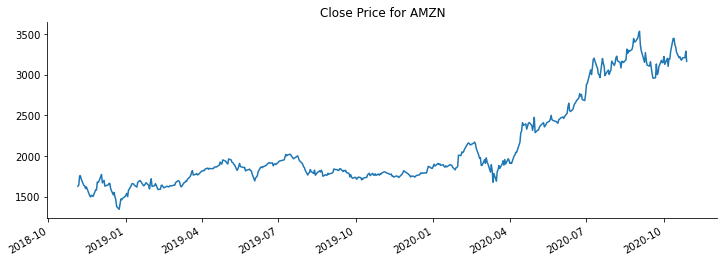

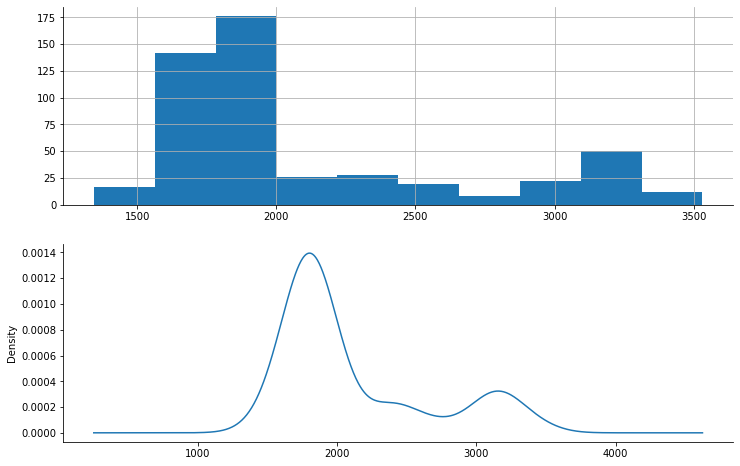

In [10]:

line(data)
histogram(data)

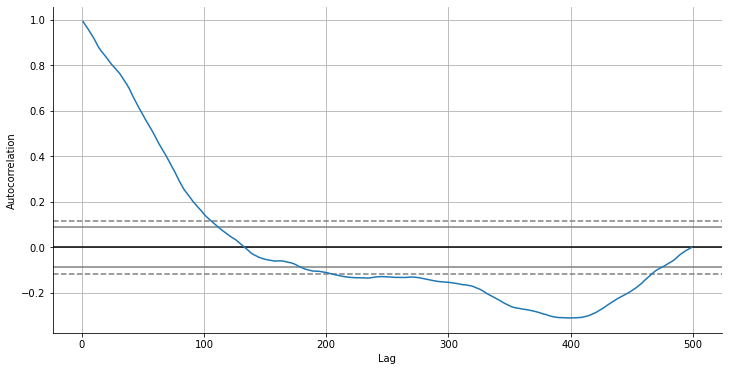

In [11]:
plt.figure(1,figsize=(12,6))
ax1=plt.subplot(111)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

autocorrelation_plot(data,ax=ax1)
plt.savefig(f'plots/{COMPANY}_autocorr.png', dpi=300, bbox_inches='tight')


In [12]:
ad_fuller(data)

ADF Statistic: 0.030902
p-value: 0.961014
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


In [13]:
print(data.describe())

count     499.000000
mean     2104.472384
std       543.429091
min      1343.959961
25%      1760.509948
50%      1864.819946
75%      2375.500000
max      3531.449951
Name: Close, dtype: float64


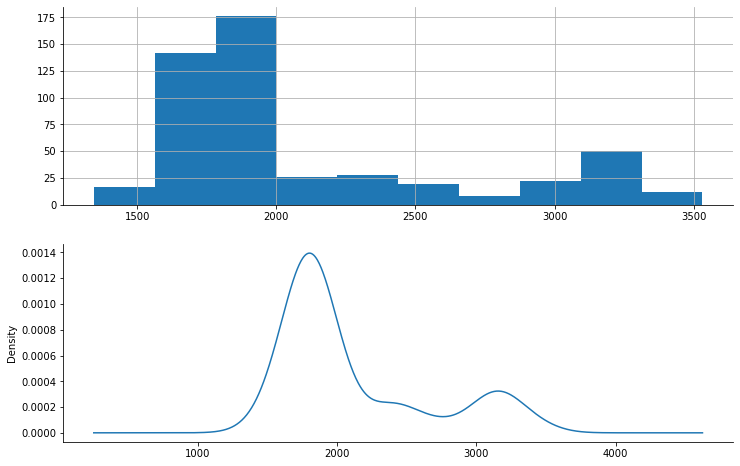

In [14]:
histogram(data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Rmse score is 284.0321817459921


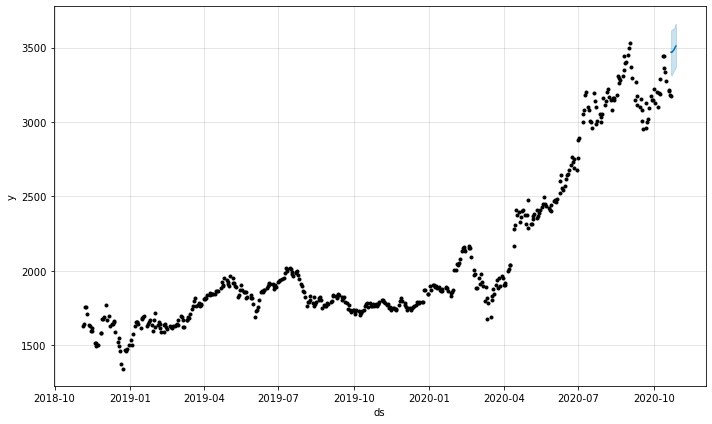

In [15]:
rmse = make_valid_prophet(data)

print(f"Rmse score is {rmse}")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Rmse score is 380.7384595431604


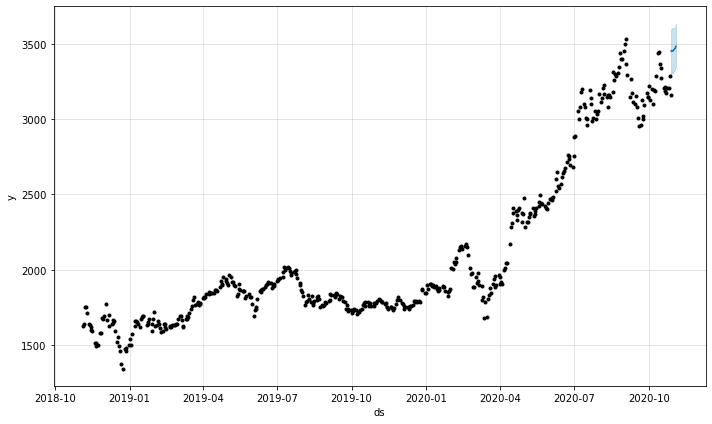

In [16]:
rmse = make_test_prophet(df_train,df_test)

print(f"Rmse score is {rmse}")

  0%|          | 0/5 [00:00<?, ?it/s]

>Predicted=3174.365, Expected=3176.400


 60%|██████    | 3/5 [00:00<00:00, 20.52it/s]

>Predicted=3176.946, Expected=3204.400
>Predicted=3201.909, Expected=3207.040
>Predicted=3208.699, Expected=3286.330


100%|██████████| 5/5 [00:00<00:00, 19.22it/s]

>Predicted=3279.256, Expected=3162.780


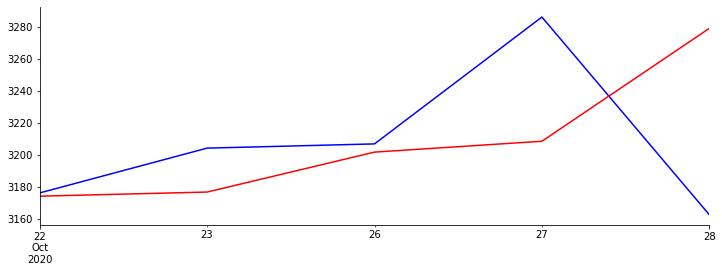

63.83959499361839

In [17]:
make_valid_arima(data)

In [18]:
data

2018-11-05    1627.800049
2018-11-06    1642.810059
2018-11-07    1755.489990
2018-11-08    1754.910034
2018-11-09    1712.430054
                 ...     
2020-10-22    3176.399902
2020-10-23    3204.399902
2020-10-26    3207.040039
2020-10-27    3286.330078
2020-10-28    3162.780029
Name: Close, Length: 499, dtype: float64

 40%|████      | 2/5 [00:00<00:00, 18.58it/s]

>Predicted=3179.286, Expected=3162.780
>Predicted=3152.747, Expected=3211.010
>Predicted=3210.199, Expected=3036.150


100%|██████████| 5/5 [00:00<00:00, 13.56it/s]

>Predicted=3055.225, Expected=3004.480
>Predicted=2998.138, Expected=3048.410


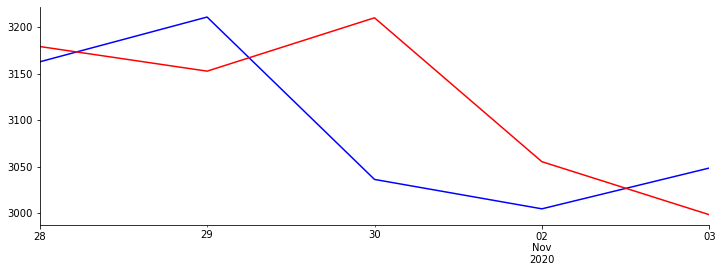

88.3882520689016

In [19]:
make_test_arima(data,test)

In [20]:
print(f"The persistence score for the model is {persistance_measure(df=df_test)} with VALID={VALID}") 

The persistence score for the model is 84.65814942702525 with VALID=1w


### BOXED VERSION

In [ ]:
data_box = box_cox_trans(data)
box_d = pd.Series(data_box[0])
box = pd.concat([pd.Series(data.index.values), pd.Series(box_d.values) ], axis=1)
box.columns=['ds','y']
series = box.set_index('ds')['y']

In [ ]:
line(series)
histogram(series)

In [ ]:
series

In [ ]:
baseline = persistance_measure(df=series)
print(f"The persistence score for the model is {baseline} with VALID={VALID}") 

In [ ]:

prophet_box = make_valid_prophet(series)

In [ ]:
arima_box = make_valid_arima(series)

In [ ]:
if arima_box < baseline:
    print("ARIMA IS BETTER")
else:
    print("BASELINE IS BETTER")

In [ ]:
if prophet_box < baseline:
    print("prophet_box IS BETTER")
else:
    print("BASELINE IS BETTER")